# Analysis

### Load Packages

In [1]:
# Load the recorded loss values from the event file
from tensorflow.python.summary.summary_iterator import summary_iterator
from tensorflow.python.framework import tensor_util
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import numpy as np
import glob
import seaborn as sns
import pandas as pd

### Setup

In [2]:
path = 'workspace/models/efficientdet_d1_coco17_tpu-32/epochs_100-batch_size_4-learning_rate_0.01-aug_False'
train_path = os.path.join(path, 'train')
val_path = os.path.join(path, 'eval')

In [21]:
# Load the evaluation metrics event file
step_values = []
train_loss_values = []
val_loss_values = []

for event in summary_iterator(os.path.join(train_path, os.listdir(train_path)[-1])):
    for value in event.summary.value:
        if value.tag == "Loss/total_loss":
            loss = tensor_util.MakeNdarray(value.tensor)
            
            if(event.step > 10_875):
                continue
            
            step_values.append(event.step)
            train_loss_values.append(loss)
 

val_files = list(glob.glob(f"{val_path}/*"))
val_files.sort(key=os.path.getctime)

for event_file in val_files:
    for event in summary_iterator(event_file):
        for value in event.summary.value:
            if value.tag == "Loss/total_loss":
                loss = tensor_util.MakeNdarray(value.tensor)
                
                if(event.step > 10_875):
                    continue
                val_loss_values.append(loss)

                
val_loss_values = val_loss_values[:108]

In [39]:
# From https://stackoverflow.com/a/68510722. Last retrieved 20.02.2023
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

In [40]:
df = pd.DataFrame({
    "steps": step_values,
    "train_loss": smooth(train_loss_values, 0.5),
    "val_loss": smooth(val_loss_values, 0.5)
})

df['train_loss'] = df['train_loss'].astype(float)
df['val_loss'] = df['val_loss'].astype(float)

In [92]:
# For the image quality of the graphic. 
sns.set(rc={"figure.dpi":300})
# For the size of the graphics
sns.set(rc = {"figure.figsize":(6,3)})

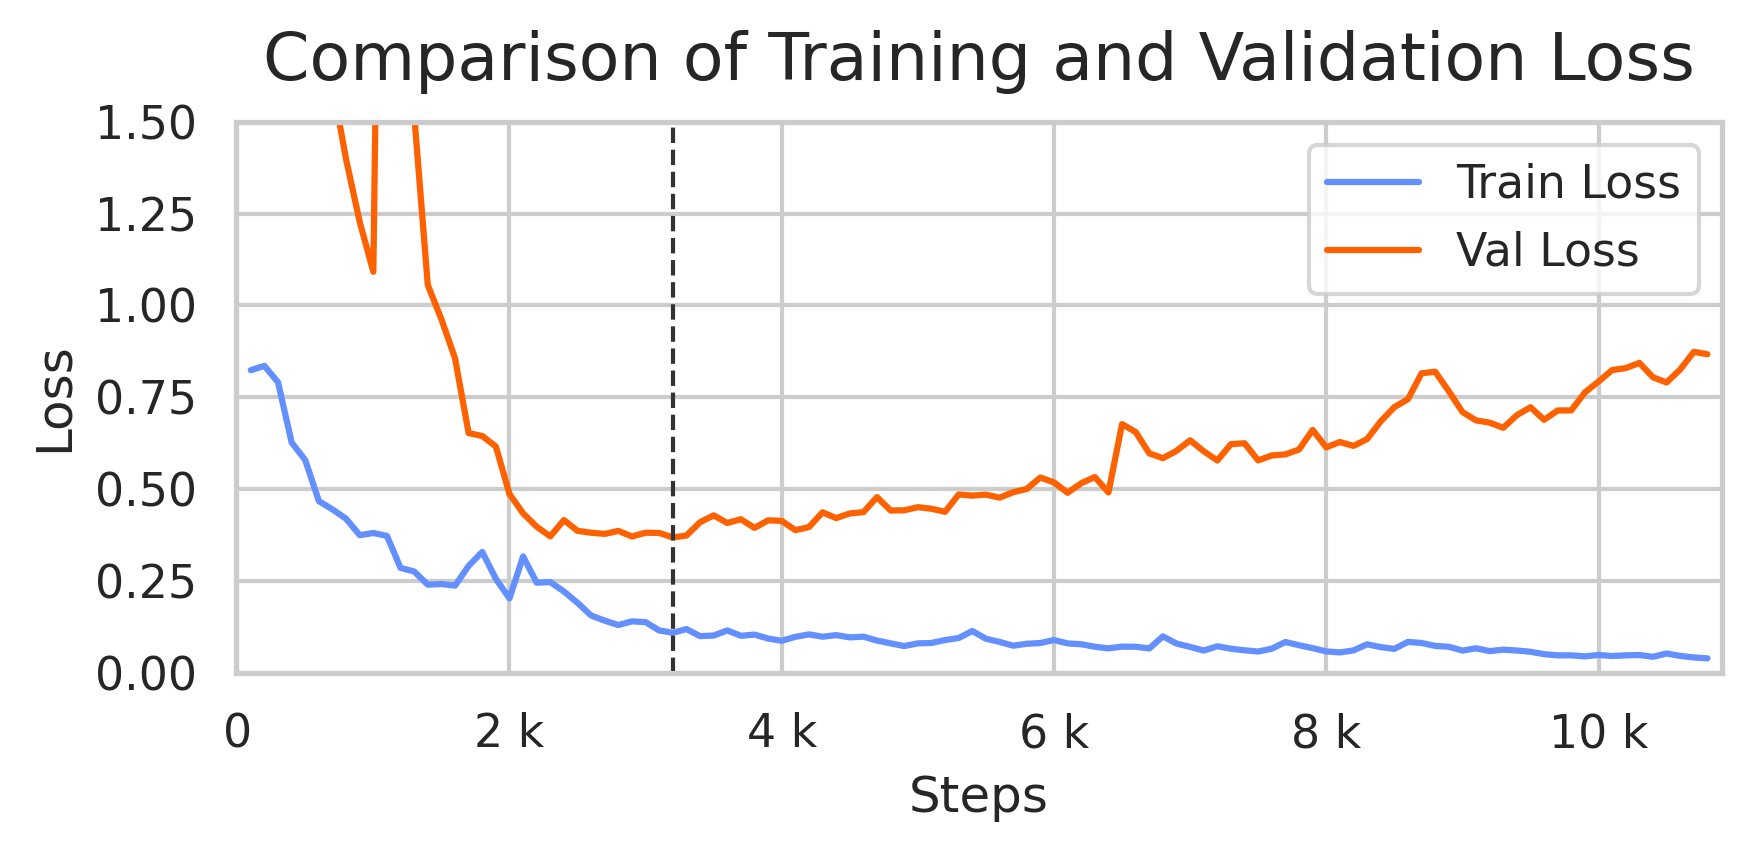

In [109]:
import matplotlib.ticker as ticker
sns.set_style("whitegrid")
# Palette from https://davidmathlogic.com/colorblind/#%23648FFF-%23785EF0-%23DC267F-%23FE6100-%23FFB000
sns.set_palette(["#648FFF", "#FE6100"])
fig, ax = plt.subplots()

sns.lineplot(data=df, x="steps", y="train_loss")
sns.lineplot(data=df, x="steps", y="val_loss")
ax.axvline(x=3200, color="#333", ls='--', lw=1)
ax.set_xlabel("Steps")
ax.set_ylabel("Loss")
ax.legend(['Train Loss', 'Val Loss'], loc='upper right')
ax.set_ylim(0, 1.5)
ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.set_title("Comparison of Training and Validation Loss", fontsize=16, pad=10)
ax.margins(x=0.01)
fig.tight_layout()
fig.savefig(os.path.join(path, 'train_val_loss.pdf'))
fig.show()